In [1]:
import uproot as ur
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Set and select run information

run = [6,7][0] # the run number to analyze
channels = {6: [5], 7: [2,6,12]}[run] # the active PMT channels in this run
time_shifts = {6: np.arange(0., 5.5, 0.5), 7: np.arange(0., 5.0, 0.05)}[run]  # the time shift in each block of data
threshold = {6: 600, 7: 600}[run]  # the ADC threshold to consider a signal
period = {6: 100000, 7: 100000}[run]  # the period of the LED flashes in ns

print(f"Run {run}: channels = {channels}, time_shifts = [{', '.join(f'{ts:.2f}' for ts in time_shifts)}], threshold = {threshold}")


Run 6: channels = [5], time_shifts = [0.00, 0.50, 1.00, 1.50, 2.00, 2.50, 3.00, 3.50, 4.00, 4.50, 5.00], threshold = 600


In [3]:
# Load the ROOT file and access the tree
file_path = f'run{run:03d}.root'
data_file = ur.open(file_path)

In [4]:
# check top level keys
data_file.keys()

['led_events;1', 'pmt_events;1']

In [5]:
# list keys in the pmt_events tree
print([key for key in list(data_file['pmt_events'].keys())])

['event_type', 'channel', 'status', 'length', 'adc', 'pmt_time', 'time_coarse', 'time_fine', 'tdc_coarse', 'tdc_start', 'tdc_stop', 'tot', 'crc']


In [6]:
# Create numpy arrays for each branch of interest

adc_values = data_file['pmt_events']['adc'].array(library='np').flatten()
channel_values = data_file['pmt_events']['channel'].array(library='np').flatten()
pmt_time_values = data_file['pmt_events']['pmt_time'].array(library='np').flatten()
time_coarse_values = data_file['pmt_events']['time_coarse'].array(library='np').flatten()
time_fine_values = data_file['pmt_events']['time_fine'].array(library='np').flatten()
tdc_start_values = data_file['pmt_events']['tdc_start'].array(library='np').flatten()

data = {
    'adc': adc_values,
    'channel': channel_values,
    'pmt_time': pmt_time_values,
    'time_coarse': time_coarse_values,
    'time_fine': time_fine_values,
    'tdc_start': tdc_start_values}

In [7]:
# Check properties of the data arrays

for key, array in data.items():
    print(f'{key}: shape={array.shape}, len={len(array)}, min={np.min(array)}, max={np.max(array)}, mean={np.mean(array)}, std={np.std(array)}, type={array.dtype}')

# Confirm meaning of the time data:
# time_coarse: 16 bit unsigned int, counts of 2^28 * 4 ns clock -> LSB = 1.07 s
# time_fine: 32 bit unsigned int, counts of 4 ns clock -> LSB = 4 ns (only lower 28 bits used)
# pmt_time: 32 bit unsigned int, time_coarse * 2^28 + time_fine, counts of 4 ns clock -> LSB = 4 ns
# tdc_start: 4 bit unsigned int, counts of 0.25 ns clock -> LSB = 0.25 ns

check_pmt_time_values = np.uint64(time_coarse_values) * (2**28) + time_fine_values
# Check that pmt_time matches calculated value
if np.array_equal(pmt_time_values, check_pmt_time_values):
    print("pmt_time matches calculated value from time_coarse and time_fine")
else:
    print("pmt_time does NOT match calculated value from time_coarse and time_fine")


adc: shape=(923749,), len=923749, min=382, max=4095, mean=1213.5221569928628, std=397.7074107317414, type=uint16
channel: shape=(923749,), len=923749, min=5, max=5, mean=5.0, std=0.0, type=uint16
pmt_time: shape=(923749,), len=923749, min=12712188883621, max=12777206604978, mean=12747183914989.887, std=16101805827.636904, type=uint64
time_coarse: shape=(923749,), len=923749, min=47356, max=47598, mean=47486.45873825032, std=59.98473726222683, type=uint16
time_fine: shape=(923749,), len=923749, min=774, max=268435413, mean=134709762.47744355, std=77733185.07333976, type=uint32
tdc_start: shape=(923749,), len=923749, min=0, max=15, mean=7.3178947960972085, std=4.010371896236931, type=uint16
pmt_time matches calculated value from time_coarse and time_fine


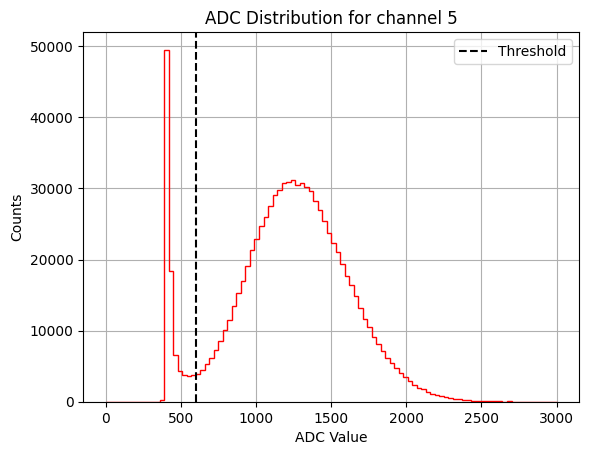

In [8]:
# plot adc distribution for the first active channel
ic = 0
mask = (channel_values == channels[ic])
plt.hist(adc_values[mask], bins=100, range=(0, 3000), histtype='step', color='red')
# overlay a vertical line for the threshold
plt.axvline(threshold, color='black', linestyle='--', label='Threshold')
plt.legend()
#plt.yscale('log')
plt.xlabel('ADC Value')
plt.ylabel('Counts')
plt.title(f'ADC Distribution for channel {channels[ic]}')
plt.grid(True)
plt.savefig(f'adc_distribution_run{run:03d}_chan{channels[ic]:02d}.png')
plt.show()

Coarse Time Range: 47356 to 47598


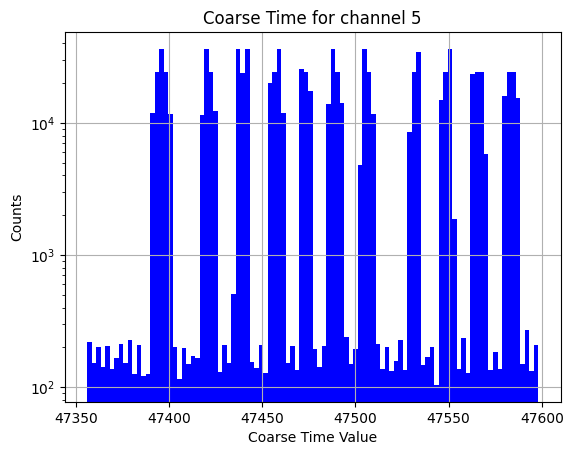

In [9]:
# plot the coarse time distribution
ic = 0
mask = (channel_values == channels[ic])

time_coarse_min = np.min(time_coarse_values[mask])
time_coarse_max = np.max(time_coarse_values[mask])
print(f"Coarse Time Range: {time_coarse_min} to {time_coarse_max}")

plt.hist(time_coarse_values[mask], bins=100, range=(time_coarse_min,time_coarse_max), color='blue')
plt.yscale('log')
plt.xlabel('Coarse Time Value')
plt.ylabel('Counts')
plt.title(f'Coarse Time for channel {channels[ic]}')
plt.grid(True)
plt.savefig(f'coarse_time_distribution_run{run:03d}_chan{channels[ic]:02d}.png')
plt.show()


In [10]:
# The data were taken in blocks with different time shifts as specified in time_shifts.
# The blocks are clearly separated in the coarse time distribution with a very small number of entries in between.

# Look at the number of entries for each time_coarse value
unique, counts = np.unique(time_coarse_values, return_counts=True)

# A new block is indicated when the count for previous coarse time value is less than 400 and the count for
# the current coarse time value is greater than 400. Likewise the block ends when the count for the current
# coarse time value is greater than 400 and the count for the next coarse time value is less than 400.

block_starts = []
block_ends = []
for i in range(1, len(unique)-1):
    if counts[i-1] < 400 and counts[i] > 400:
        block_starts.append(unique[i])
    if counts[i] > 400 and counts[i+1] < 400:
        block_ends.append(unique[i])

# Check that the number of time shifts matches the number of blocks found
if len(block_starts) != len(time_shifts) or len(block_ends) != len(time_shifts):
    print(f"Warning: number of blocks found ({len(block_starts)}) does not match number of time shifts ({len(time_shifts)})")

# Print summary: block number, time_shift, start, end, number of entries
for i, (start, end) in enumerate(zip(block_starts, block_ends)):
    num_entries = np.sum((time_coarse_values >= start) & (time_coarse_values <= end))
    print(f"Block {i}: time_shift = {time_shifts[i]}, Start = {start}, End = {end}, Number of Entries = {num_entries}")


Block 0: time_shift = 0.0, Start = 47392, End = 47400, Number of Entries = 107949
Block 1: time_shift = 0.5, Start = 47418, End = 47424, Number of Entries = 83680
Block 2: time_shift = 1.0, Start = 47435, End = 47443, Number of Entries = 96549
Block 3: time_shift = 1.5, Start = 47454, End = 47461, Number of Entries = 91982
Block 4: time_shift = 2.0, Start = 47470, End = 47476, Number of Entries = 67123
Block 5: time_shift = 2.5, Start = 47485, End = 47493, Number of Entries = 88120
Block 6: time_shift = 3.0, Start = 47503, End = 47509, Number of Entries = 76511
Block 7: time_shift = 3.5, Start = 47530, End = 47535, Number of Entries = 66896
Block 8: time_shift = 4.0, Start = 47546, End = 47553, Number of Entries = 77004
Block 9: time_shift = 4.5, Start = 47563, End = 47569, Number of Entries = 77180
Block 10: time_shift = 5.0, Start = 47580, End = 47587, Number of Entries = 79350


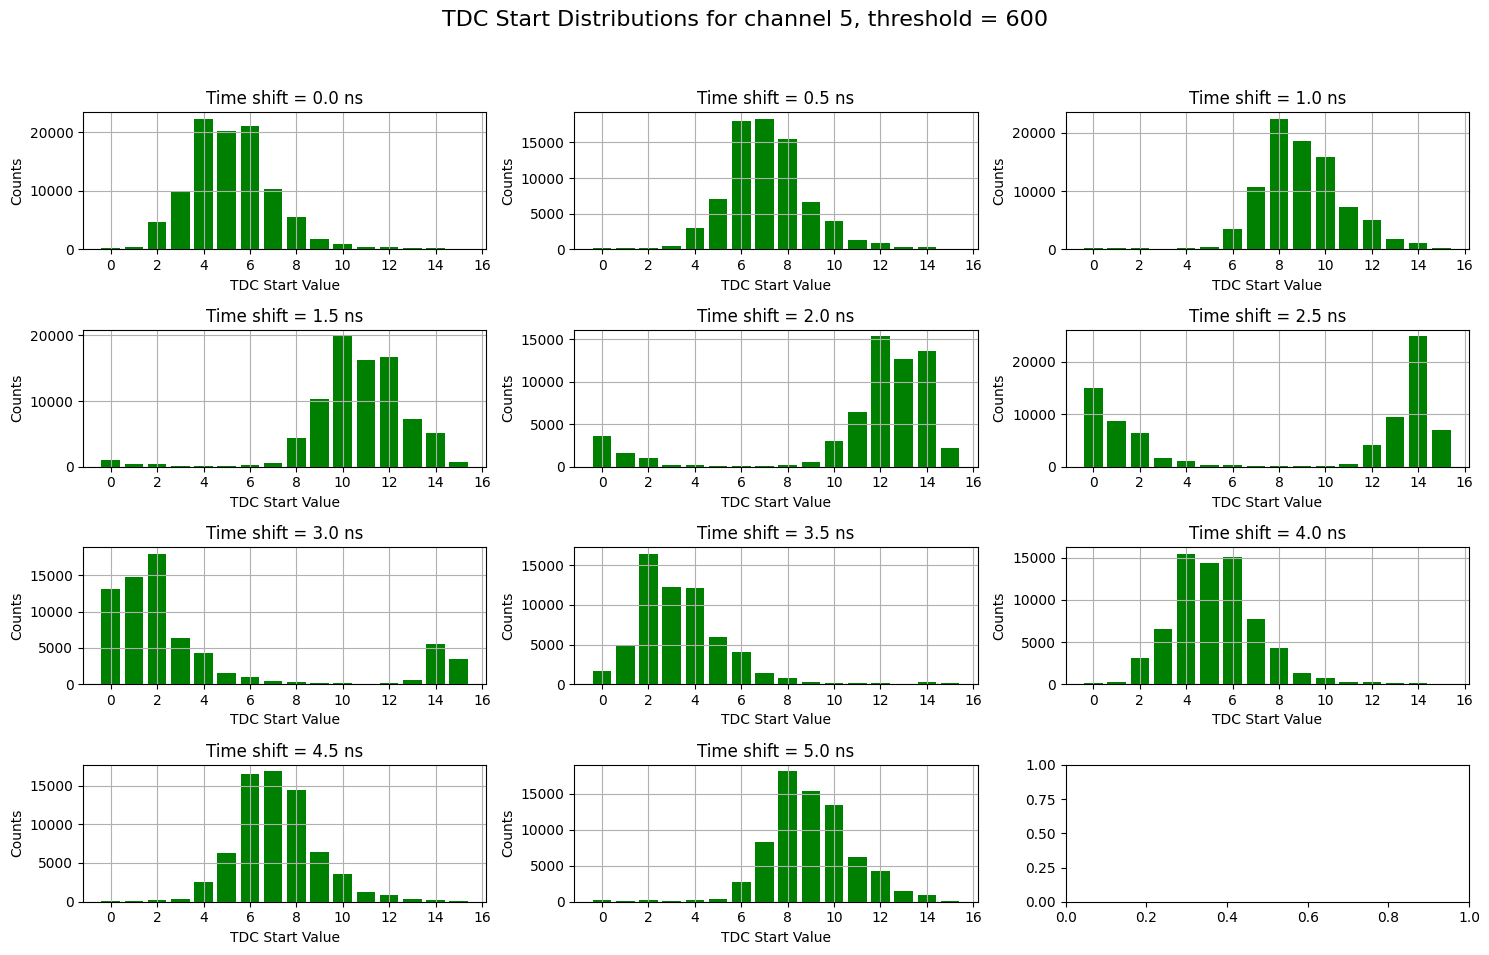

In [11]:
# Show the distribution for tdc_start for entries in each block and adc > 600
# The tdc_start value is a 4 bit number (0 to 15) so we can use 15 bins
# each block in a separate subplot, and offset is the title - be sure to leave some space between the plots

ic = 0  # channel index to plot

fig, axs = plt.subplots(4, 3, figsize=(15, 10))
fig.suptitle(f'TDC Start Distributions for channel {channels[ic]}, threshold = {threshold}', fontsize=16)
axs = axs.flatten()
for i, (start, end) in enumerate(zip(block_starts, block_ends)):
    mask = (time_coarse_values >= start) & (time_coarse_values <= end) & (adc_values > 600) & (channel_values == channels[ic])
    axs[i].hist(tdc_start_values[mask], bins= np.arange(0, 17, 1), color='green', align='left', rwidth=0.8)
    axs[i].set_title(f'Time shift = {time_shifts[i]} ns')
    axs[i].set_xlabel('TDC Start Value')
    axs[i].set_ylabel('Counts')
    axs[i].grid(True)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig(f'tdc_start_distributions_run{run:03d}_chan{channels[ic]:02d}.png')
plt.show()


Minimum significant modulus: 10581.0, Maximum significant modulus: 10677.0
Difference: 16.0 between 10581.0 and 10597.0
Difference: 16.0 between 10597.0 and 10613.0
Difference: 16.0 between 10613.0 and 10629.0
Difference: 16.0 between 10629.0 and 10645.0
Difference: 16.0 between 10645.0 and 10661.0
Difference: 16.0 between 10661.0 and 10677.0


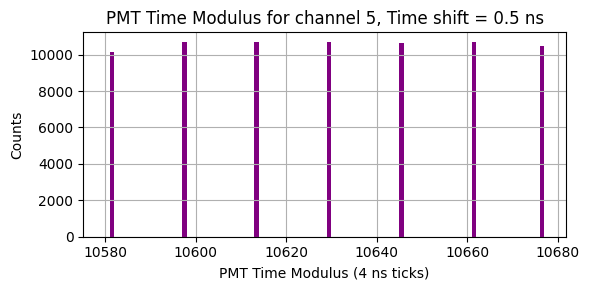

In [12]:
# The distribution of TDC start values shown above are missing the next higher bit
# Use the known period of flashes
clock_period = period / 4  # in units of 4 ns clock ticks that defines the fine time
# choose a block which TDC start values are centered around 8
ic = 0
ib = 1
# find the modulus of pmt_time with respect to the clock period
mask = (time_coarse_values >= block_starts[ib]) & (time_coarse_values <= block_ends[ib]) & (adc_values > 600) & (channel_values == channels[ic])
pmt_time_modulus = pmt_time_values[mask] % clock_period
# find the unique values and their counts
unique, counts = np.unique(pmt_time_modulus, return_counts=True)
# find the values having at least 20 counts and save the minimum and maximum modulus values
mask_count = (counts >= 20)
min_modulus = unique[mask_count][0]
max_modulus = unique[mask_count][-1]
print(f'Minimum significant modulus: {min_modulus}, Maximum significant modulus: {max_modulus}')
for i in range(1, len(unique[mask_count])):
    print(f'Difference: {unique[mask_count][i]-unique[mask_count][i-1]} between {unique[mask_count][i-1]} and {unique[mask_count][i]}')

bins = np.arange(min_modulus-1, max_modulus+1, 1)
# show the distribution of the modulus values over that range
# make the plot have aspect ratio of 2:1
# make sure that the bottom label is not cut off
plt.figure(figsize=(6, 3))
plt.hist(pmt_time_modulus, bins=bins, color='purple')
plt.xlabel('PMT Time Modulus (4 ns ticks)')
plt.ylabel('Counts')
plt.title(f'PMT Time Modulus for channel {channels[ic]}, Time shift = {time_shifts[ib]} ns')
plt.grid(True)
plt.tight_layout()
plt.savefig(f'pmt_time_modulus_run{run:03d}_chan{channels[ic]:02d}_block{ib}.png')
plt.show()


In [13]:
# Show that there is a bug that adds 64 ns every second to the fine time
# look at the coarse time for the first event in each of these unique modulus values with significant counts
for um in unique[mask_count]:
    sel_coarse_times = time_coarse_values[mask][pmt_time_modulus == um]
    sel_pmt_time_mods = pmt_time_values[mask][pmt_time_modulus == um] % clock_period
    # print the first coarse time and fine time for this modulus value
    first_coarse_time = sel_coarse_times[0]
    first_pmt_time_mod = sel_pmt_time_mods[0]
     # print the modulus value, first coarse time, and first fine time
    print(f'Modulus: {um}, First Coarse Time: {first_coarse_time}, First PMT Time Modulus: {int(first_pmt_time_mod)}')


Modulus: 10581.0, First Coarse Time: 47418, First PMT Time Modulus: 10581
Modulus: 10597.0, First Coarse Time: 47419, First PMT Time Modulus: 10597
Modulus: 10613.0, First Coarse Time: 47420, First PMT Time Modulus: 10613
Modulus: 10629.0, First Coarse Time: 47421, First PMT Time Modulus: 10629
Modulus: 10645.0, First Coarse Time: 47422, First PMT Time Modulus: 10645
Modulus: 10661.0, First Coarse Time: 47423, First PMT Time Modulus: 10661
Modulus: 10677.0, First Coarse Time: 47424, First PMT Time Modulus: 10677


In [14]:
# The bug can be removed by subtracting 16 from the fine time for every increment of the time_coarse
# Find the lowest coarse time in the dataset that has adc > threshold
ic = 0
mask = (adc_values > threshold) & (channel_values == channels[ic])
min_coarse_time = np.min(time_coarse_values[mask])
print(f'Minimum coarse time with adc > {threshold}: {min_coarse_time}')
# create a corrected pmt_time array
corrected_pmt_time_values = pmt_time_values - 16 * (time_coarse_values - min_coarse_time)

Minimum coarse time with adc > 600: 47356


Minimum significant modulus: 9589.0, Maximum significant modulus: 9590.0
Difference: 1.0 between 9589.0 and 9590.0


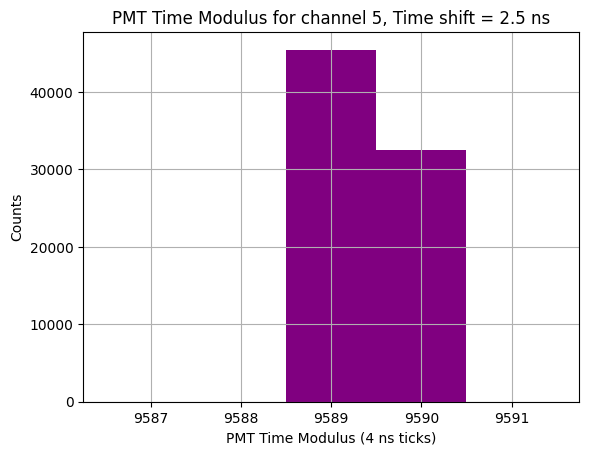

In [15]:
# The distribution of TDC start values shown above are missing the next higher bit
# Use the known period of flashes
clock_period = period / 4  # in units of 4 ns clock ticks that defines the fine time
# choose a block which TDC start values are centered around 8
ic = 0
ib = 5
# find the modulus of pmt_time with respect to the clock period
mask = (time_coarse_values >= block_starts[ib]) & (time_coarse_values <= block_ends[ib]) & (adc_values > 600) & (channel_values == channels[ic])
pmt_time_modulus = corrected_pmt_time_values[mask] % clock_period
# find the unique values and their counts
unique, counts = np.unique(pmt_time_modulus, return_counts=True)
# find the values having at least 20 counts and save the minimum and maximum modulus values
mask_count = (counts >= 20)
min_modulus = unique[mask_count][0]
max_modulus = unique[mask_count][-1]
print(f'Minimum significant modulus: {min_modulus}, Maximum significant modulus: {max_modulus}')
for i in range(1, len(unique[mask_count])):
    print(f'Difference: {unique[mask_count][i]-unique[mask_count][i-1]} between {unique[mask_count][i-1]} and {unique[mask_count][i]}')

# choose the modulus with the most events
selected_pmt_time_modulus = unique[np.argmax(counts)]

bins = np.arange(selected_pmt_time_modulus-2, selected_pmt_time_modulus+4, 1)
# show the distribution of the modulus values over that range
plt.hist(pmt_time_modulus, bins=bins, color='purple', align='left')
plt.xlabel('PMT Time Modulus (4 ns ticks)')
plt.ylabel('Counts')
plt.title(f'PMT Time Modulus for channel {channels[ic]}, Time shift = {time_shifts[ib]} ns')
plt.grid(True)
plt.savefig(f'corrected_pmt_time_modulus_run{run:03d}_chan{channels[ic]:02d}_block{ib}.png')
plt.show()


In [16]:
# Show that there is a bug that adds 64 ns every second to the fine time
# look at the coarse time for the first event in each of these unique modulus values with significant counts
# Sometimes there are a few entries far away from the main cluster (in run 6 that occurs at ib = 0 and 1)
for um in unique[mask_count]:
    sel_coarse_times = time_coarse_values[mask][pmt_time_modulus == um]
    sel_pmt_time_mods = corrected_pmt_time_values[mask][pmt_time_modulus == um] % clock_period
    sel_adcs = adc_values[mask][pmt_time_modulus == um]
    # print the first coarse time and fine time for this modulus value
    first_coarse_time = sel_coarse_times[0]
    first_pmt_time_mod = sel_pmt_time_mods[0]
     # print the modulus value, first coarse time, and first fine time
    print(f'Modulus: {um}, First Coarse Time: {first_coarse_time}, First PMT Time Modulus: {int(first_pmt_time_mod)}, number of entries: {len(sel_coarse_times)}, mean adc: {np.mean(sel_adcs)}')

Modulus: 9589.0, First Coarse Time: 47485, First PMT Time Modulus: 9589, number of entries: 45441, mean adc: 1455.955744811954
Modulus: 9590.0, First Coarse Time: 47485, First PMT Time Modulus: 9590, number of entries: 32456, mean adc: 1097.0419336948485


In [17]:
# Count the number of flashes seen in the data compared to the number of function generator pulses
# make a table showing for each block:
# time_shift, duration, # pulses, # signals, f_0, and E[Npe]
ic = 0

print(f"| {'Time Shift (ns)':>15} | {'Duration (s)':>10} | {'# Pulses':>10} | {'# Signals':>10} | {'f0':>17} | {'E[Npe]':>15} |")
print('|------'*6 + '|')
for ib in range(len(block_starts)):
    mask = (time_coarse_values >= block_starts[ib]) & (time_coarse_values <= block_ends[ib]) & (adc_values > threshold) & (channel_values == channels[ic])
    pmt_time_modulus_zeroed = corrected_pmt_time_values[mask] % clock_period - selected_pmt_time_modulus
    signal_times = pmt_time_modulus_zeroed * 4 + tdc_start_values[mask]/4.  # in ns
    signal_times = signal_times[(-50 < signal_times) & (signal_times < 50)]
    num_signals = len(signal_times)
    first_corrected_pmt_time = np.min(corrected_pmt_time_values[mask])
    last_corrected_pmt_time = np.max(corrected_pmt_time_values[mask])
    duration_ns = (last_corrected_pmt_time - first_corrected_pmt_time) * 4  # in ns
    num_pulses = duration_ns / period
    fraction_no_signal = (num_pulses - num_signals) / num_pulses if num_pulses > 0 else 0
    npe_expected = -np.log(fraction_no_signal) if fraction_no_signal > 0 else float('inf')
#    print(f'Block {ib}: Time shift = {time_shifts[ib]} ns, # signals = {num_signals}, # fg pulses = {num_pulses:.1f}, Duration = {duration_ns/1e9:.2f} s, Fraction with no signal = {fraction_no_signal:.3f}, Npe expected = {npe_expected:.2f}')
    print(f'| {time_shifts[ib]:15.2f} | {duration_ns/1e9:10.2f} | {num_pulses:10.1f} | {num_signals:10d} | {fraction_no_signal:17.3f} | {npe_expected:15.2f} |')

| Time Shift (ns) | Duration (s) |   # Pulses |  # Signals |                f0 |          E[Npe] |
|------|------|------|------|------|------|
|            0.00 |       9.60 |    96033.0 |      95535 |             0.005 |            5.26 |
|            0.50 |       7.46 |    74620.9 |      74023 |             0.008 |            4.83 |
|            1.00 |       9.64 |    96414.1 |      85442 |             0.114 |            2.17 |
|            1.50 |       8.48 |    84804.6 |      81344 |             0.041 |            3.20 |
|            2.00 |       7.49 |    74871.5 |      59388 |             0.207 |            1.58 |
|            2.50 |       9.55 |    95543.8 |      77897 |             0.185 |            1.69 |
|            3.00 |       7.49 |    74877.0 |      67781 |             0.095 |            2.36 |
|            3.50 |       6.30 |    63026.2 |      59268 |             0.060 |            2.82 |
|            4.00 |       8.42 |    84164.5 |      68080 |             0.191 |   

| Time Shift (ns) | Duration (s) |   # Pulses |  # Signals |                f0 |          E[Npe] |
|------|------|------|------|------|------|
|            0.00 |       9.60 |    96033.0 |      95535 |             0.005 |            5.26 |
|            0.50 |       7.46 |    74620.9 |      74023 |             0.008 |            4.83 |
|            1.00 |       9.64 |    96414.1 |      85442 |             0.114 |            2.17 |
|            1.50 |       8.48 |    84804.6 |      81344 |             0.041 |            3.20 |
|            2.00 |       7.49 |    74871.5 |      59388 |             0.207 |            1.58 |
|            2.50 |       9.55 |    95543.8 |      77897 |             0.185 |            1.69 |
|            3.00 |       7.49 |    74877.0 |      67781 |             0.095 |            2.36 |
|            3.50 |       6.30 |    63026.2 |      59268 |             0.060 |            2.82 |
|            4.00 |       8.42 |    84164.5 |      68080 |             0.191 |            1.65 |
|            4.50 |       7.41 |    74148.0 |      68337 |             0.078 |            2.55 |
|            5.00 |       8.44 |    84413.8 |      70155 |             0.169 |            1.78 |

| Time Shift (ns) | Duration (s) |   # Pulses |  # Signals |                f0 |          E[Npe] |
|------|------|------|------|------|------|
|            0.00 |       9.60 |    96000.0 |      95501 |            0.0052 |            5.26 |
|            0.50 |       7.42 |    74200.0 |      73788 |            0.0056 |            5.19 |
|            1.00 |       8.44 |    84400.0 |      83784 |            0.0073 |            4.92 |
|            1.50 |       7.98 |    79800.0 |      79327 |            0.0059 |            5.13 |
|            2.00 |       5.70 |    57000.0 |      56676 |            0.0057 |            5.17 |
|            2.50 |       7.20 |    72000.0 |      71597 |            0.0056 |            5.19 |
|            3.00 |       6.68 |    66800.0 |      66304 |            0.0074 |            4.90 |
|            3.50 |       5.60 |    56000.0 |      55680 |            0.0057 |            5.16 |
|            4.00 |       6.30 |    63000.0 |      62656 |            0.0055 |   

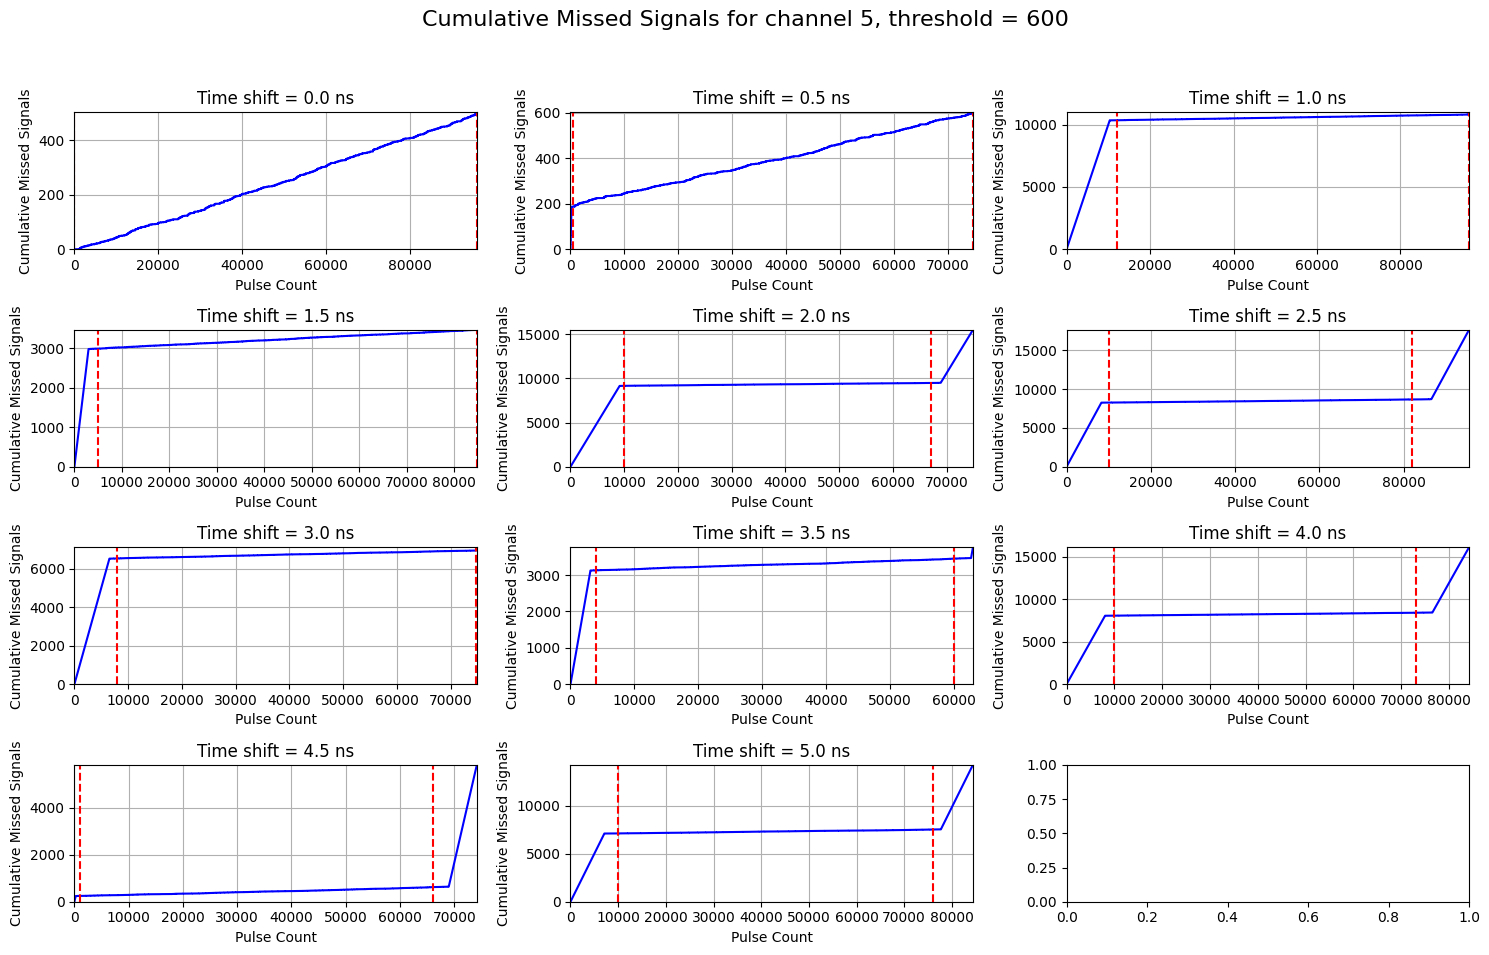

In [18]:
# Look at the accumulation of pulses without signals
# For each block, make a plot showing the cumulative number of missing signals vs time
# Use the corrected pmt_time values

pulse_counter_ranges = [[0,96000],[400,74600],[12000,96400],[5000,84800],[10000,67000],[10000,82000],
                        [8000,74800],[4000,60000],[10000,73000],[1000,66000],[10000,76000]]  # range of pulse counter to use

ic = 0

print(f"| {'Time Shift (ns)':>15} | {'Duration (s)':>10} | {'# Pulses':>10} | {'# Signals':>10} | {'f0':>17} | {'E[Npe]':>15} |")
print('|------'*6 + '|')

fig, axs = plt.subplots(4, 3, figsize=(15, 10))
fig.suptitle(f'Cumulative Missed Signals for channel {channels[ic]}, threshold = {threshold}', fontsize=16)
axs = axs.flatten()
for ib in range(len(block_starts)):
    mask = (time_coarse_values >= block_starts[ib]) & (time_coarse_values <= block_ends[ib]) & (adc_values > threshold) & (channel_values == channels[ic])
    pmt_time_modulus_zeroed = corrected_pmt_time_values[mask] % clock_period - selected_pmt_time_modulus
    pulse_counter = corrected_pmt_time_values[mask] // clock_period
    pulse_counter = pulse_counter - pulse_counter[0]
    signal_times_all = pmt_time_modulus_zeroed * 4 + tdc_start_values[mask]/4.  # in ns
    signal_times = signal_times_all[(-50 < signal_times_all) & (signal_times_all < 50)]
    pulse_counter_seen = pulse_counter[(-50 < signal_times_all) & (signal_times_all < 50)]

    num_signals = len(signal_times)
    first_corrected_pmt_time = np.min(corrected_pmt_time_values[mask])
    last_corrected_pmt_time = np.max(corrected_pmt_time_values[mask])
    duration_ns = (last_corrected_pmt_time - first_corrected_pmt_time) * 4  # in ns
    num_pulses = duration_ns / period
    num_misses = int(num_pulses) - num_signals

    sum_misses = 0
    cumulative_misses = []
    for i in range(int(num_pulses)):
        if i not in pulse_counter_seen:
            sum_misses += 1
        cumulative_misses.append(sum_misses)
    cumulative_misses = np.array(cumulative_misses)

    cor_duration_ns = (pulse_counter_ranges[ib][1] - pulse_counter_ranges[ib][0]) * period
    cor_num_pulses = pulse_counter_ranges[ib][1] - pulse_counter_ranges[ib][0]
    cor_num_misses = cumulative_misses[pulse_counter_ranges[ib][1]-1] - cumulative_misses[pulse_counter_ranges[ib][0]-1] if pulse_counter_ranges[ib][0] > 0 else cumulative_misses[pulse_counter_ranges[ib][1]-1]
    cor_num_signals = cor_num_pulses - cor_num_misses
    cor_fraction_no_signal = cor_num_misses / cor_num_pulses
    cor_npe_expected = -np.log(cor_fraction_no_signal) if cor_fraction_no_signal > 0 else float('inf')

    print(f'| {time_shifts[ib]:15.2f} | {cor_duration_ns/1e9:10.2f} | {cor_num_pulses:10.1f} | {cor_num_signals:10d} | {cor_fraction_no_signal:17.4f} | {cor_npe_expected:15.2f} |')

    axs[ib].step(np.arange(len(cumulative_misses)), cumulative_misses, where='mid', color='blue')
    axs[ib].axvline(pulse_counter_ranges[ib][0], color='red', linestyle='--')
    axs[ib].axvline(pulse_counter_ranges[ib][1], color='red', linestyle='--')
    axs[ib].set_xlim(0, len(cumulative_misses))
    axs[ib].set_ylim(0, num_misses + 5)
    axs[ib].set_title(f'Time shift = {time_shifts[ib]} ns')
    axs[ib].set_xlabel('Pulse Count')
    axs[ib].set_ylabel('Cumulative Missed Signals')
    axs[ib].grid(True)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig(f'cumulative_missed_signals_run{run:03d}_chan{channels[ic]:02d}.png')
plt.show()



| Time Shift (ns) | Duration (s) |   # Pulses |  # Signals |                f0 |          E[Npe] |
|------|------|------|------|------|------|
|            0.00 |       9.60 |    96000.0 |      95501 |            0.0052 |            5.26 |
|            0.50 |       7.42 |    74200.0 |      73788 |            0.0056 |            5.19 |
|            1.00 |       8.44 |    84400.0 |      83784 |            0.0073 |            4.92 |
|            1.50 |       7.98 |    79800.0 |      79327 |            0.0059 |            5.13 |
|            2.00 |       5.70 |    57000.0 |      56676 |            0.0057 |            5.17 |
|            2.50 |       7.20 |    72000.0 |      71597 |            0.0056 |            5.19 |
|            3.00 |       6.68 |    66800.0 |      66304 |            0.0074 |            4.90 |
|            3.50 |       5.60 |    56000.0 |      55680 |            0.0057 |            5.16 |
|            4.00 |       6.30 |    63000.0 |      62656 |            0.0055 |            5.21 |
|            4.50 |       6.50 |    65000.0 |      64626 |            0.0058 |            5.16 |
|            5.00 |       6.60 |    66000.0 |      65591 |            0.0062 |            5.08 |

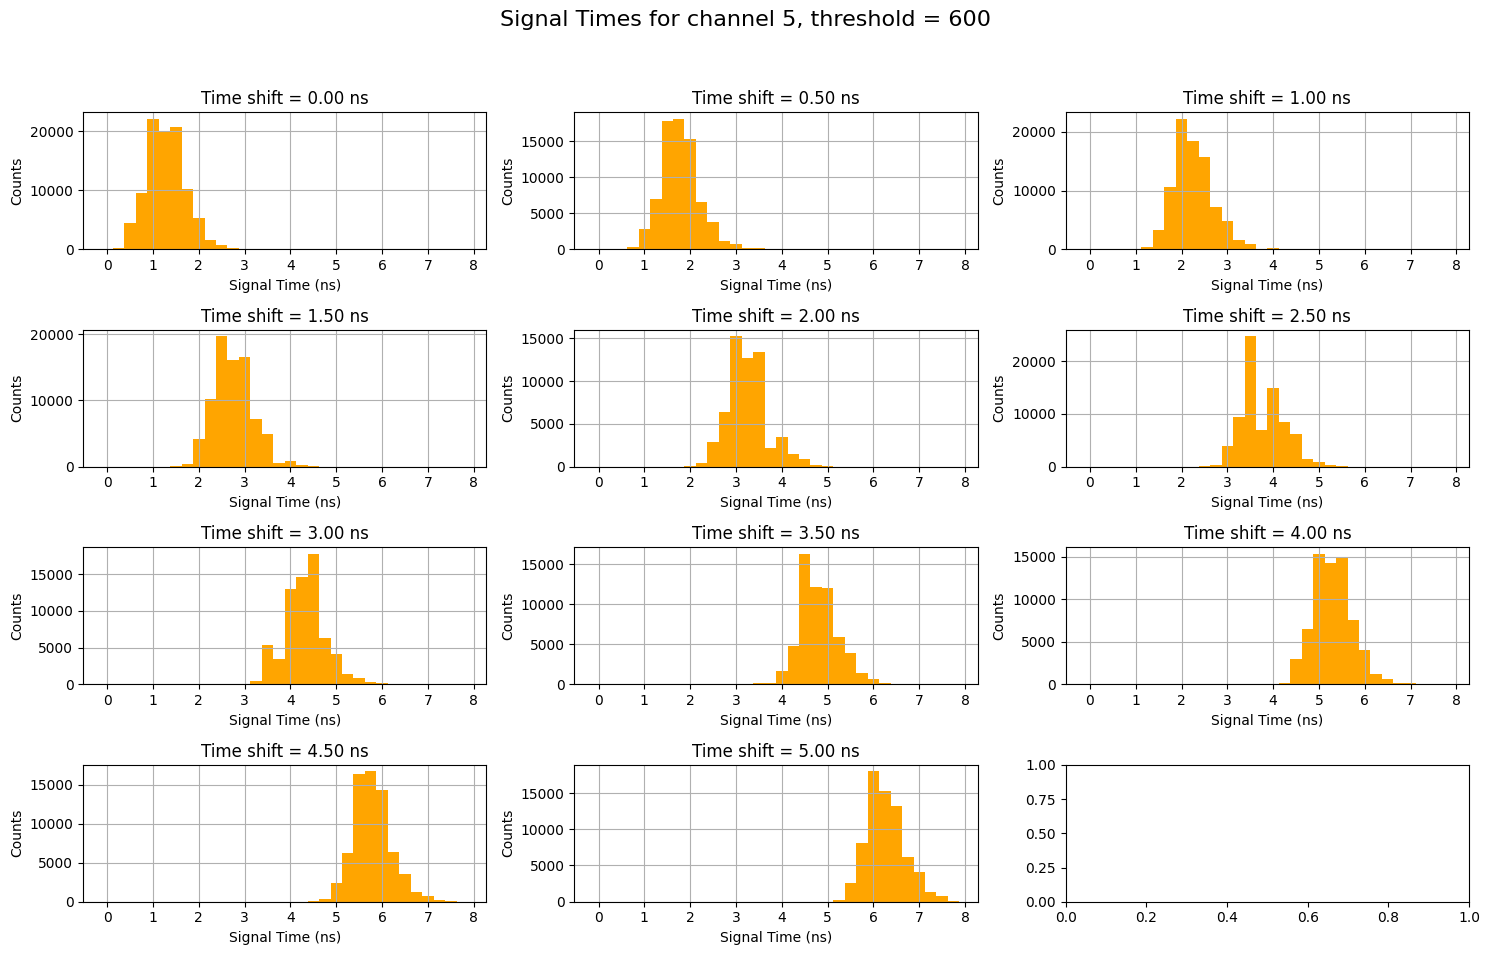

In [19]:
# Now we can look at the full timing of the signals, modulus the 100 us period of the LED flashes
# We will use the corrected pmt_time values
# Show the distributions for each block in a separate subplot
signal_times_by_blocks = []
ic = 0  # channel index to plot
fig, axs = plt.subplots(4, 3, figsize=(15, 10))
fig.suptitle(f'Signal Times for channel {channels[ic]}, threshold = {threshold}', fontsize=16)
axs = axs.flatten()
for i, (start, end) in enumerate(zip(block_starts, block_ends)):
    mask = (time_coarse_values >= start) & (time_coarse_values <= end) & (adc_values > threshold) & (channel_values == channels[ic])
    pmt_time_modulus_zeroed = corrected_pmt_time_values[mask] % clock_period - selected_pmt_time_modulus
    signal_times = pmt_time_modulus_zeroed * 4 + tdc_start_values[mask]/4.  # in ns
    signal_times = signal_times[(-50 < signal_times) & (signal_times < 50)]  # keep only times within -50 to 50 ns
    signal_times_by_blocks.append(signal_times)
    axs[i].hist(signal_times, bins= np.arange(0, 8.25, 0.25), color='orange', align='left')
    axs[i].set_title(f'Time shift = {time_shifts[i]:.2f} ns')
    axs[i].set_xlabel('Signal Time (ns)')
    axs[i].set_ylabel('Counts')
    axs[i].grid(True)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig(f'signal_times_run{run:03d}_chan{channels[ic]:02d}.png')
plt.show()

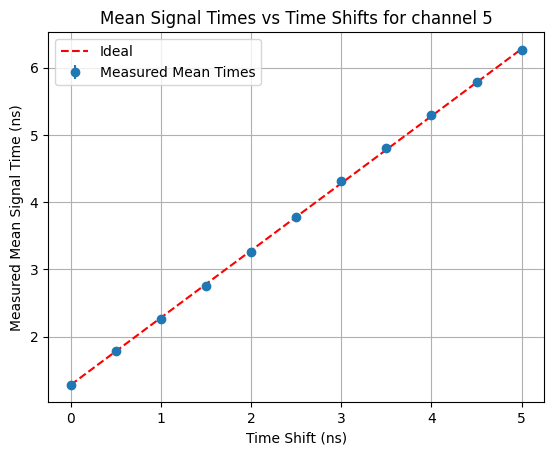

In [20]:
# Look at the response based on mean and RMS of each block
mean_times = [np.mean(st) for st in signal_times_by_blocks]
rms_times = [np.std(st) for st in signal_times_by_blocks]
error_times = [rms/np.sqrt(len(st)) for rms, st in zip(rms_times, signal_times_by_blocks)]
# find offsets with respect to the time_shifts
offsets_measured = [mean_times[i] - time_shifts[i] for i in range(len(mean_times))]
mean_offset = np.mean(offsets_measured)

# plot the mean times with error bars
plt.errorbar(time_shifts, mean_times, yerr=error_times, fmt='o', label='Measured Mean Times')
# plot the ideal line
plt.plot(time_shifts, time_shifts + mean_offset, 'r--', label='Ideal')
plt.xlabel('Time Shift (ns)')
plt.ylabel('Measured Mean Signal Time (ns)')
plt.title(f'Mean Signal Times vs Time Shifts for channel {channels[ic]}')
plt.legend()
plt.grid(True)
plt.savefig(f'mean_signal_times_run{run:03d}_chan{channels[ic]:02d}.png')
plt.show()

In [21]:
# print summary:
print(f"Mean offset (measured - ideal): {mean_offset:.2f} ns")
print(f"Mean of RMS values: {np.mean(rms_times):.2f} ns")
print("Time Shift (ns) | Measured Mean Time (ns) | RMS (ns) | Number of Entries")
for i in range(len(mean_times)):
    print(f"{time_shifts[i]:15.2f} | {mean_times[i]:22.2f} | {rms_times[i]:7.2f} | {len(signal_times_by_blocks[i]):17d}")


Mean offset (measured - ideal): 1.28 ns
Mean of RMS values: 0.46 ns
Time Shift (ns) | Measured Mean Time (ns) | RMS (ns) | Number of Entries
           0.00 |                   1.29 |    0.45 |             95535
           0.50 |                   1.78 |    0.41 |             74023
           1.00 |                   2.26 |    0.44 |             85442
           1.50 |                   2.75 |    0.47 |             81344
           2.00 |                   3.26 |    0.47 |             59388
           2.50 |                   3.77 |    0.47 |             77897
           3.00 |                   4.31 |    0.45 |             67781
           3.50 |                   4.81 |    0.43 |             59268
           4.00 |                   5.30 |    0.43 |             68080
           4.50 |                   5.79 |    0.47 |             68337
           5.00 |                   6.27 |    0.51 |             70155


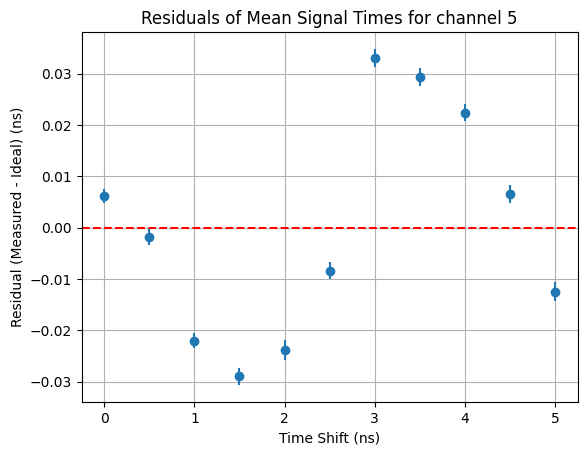

In [22]:
# Look at the residual between measured and ideal
residuals = [mean_times[i] - (time_shifts[i] + mean_offset) for i in range(len(mean_times))]
plt.errorbar(time_shifts, residuals, yerr=error_times, fmt='o')
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Time Shift (ns)')
plt.ylabel('Residual (Measured - Ideal) (ns)')
plt.title(f'Residuals of Mean Signal Times for channel {channels[ic]}')
plt.grid(True)
plt.savefig(f'residuals_signal_times_run{run:03d}_chan{channels[ic]:02d}.png')
plt.show()